# WGAN Model and Training on MNIST

In [71]:
# Import the libraries required
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


### Hyperparameters

In [72]:
# Constants
image_resize_dimension = 64
batch_size = 64
real_label = 1
fake_label = 0

# Hyper parameters
image_channels = 1
z_dim = 100
hidden_dim_size = 32
learning_rate = 0.0001
num_epochs = 20
clip_value = 0.01  # Adjust as needed

In [73]:
# LOAD MNIST Data
# Mnist transform to preprocess the data
transcform_mnist_norm = transforms.Normalize((0.5,),(0.5,)).to(default_device)
transform_mnist = transforms.Compose([transforms.ToTensor(), transcform_mnist_norm, transforms.Resize(image_resize_dimension)])

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size, shuffle=True)

In [74]:
# Print some of the MNIST dataset if flag is set
print_sample = False
if print_sample:
    real_batch = next(iter(trainloader_mnist))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [75]:
# Proper way to initialize weights for the generator and discriminator networks based on reasearch paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [76]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden_layer_size=64, img_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(z_dim, hidden_layer_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 8, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 4, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 2, hidden_layer_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(hidden_layer_size, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(default_device)

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, hidden_layer_size=64, img_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            # For the gradient penalty, the batchnorm cannot be used, since we penalize the norm of the critic's gradient with respect to each input independently
            # Use InstanceNorm2d instead of BatchNorm2d

            # 1st layer
            nn.Conv2d(img_channels, hidden_layer_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(hidden_layer_size, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(hidden_layer_size * 2, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(hidden_layer_size * 4, hidden_layer_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # # Output layer is not a probability! So no sigmoid, just another layer
            nn.Conv2d(hidden_layer_size * 8, 1, 4, 1, 0, bias=False),
        ).to(default_device)

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [77]:
# Initialize BCELoss function
criterion = nn.BCELoss()

generator = Generator(z_dim, hidden_dim_size, image_channels)
generator.apply(weights_init)
# print(generator_cifar)
discriminator = Discriminator(hidden_dim_size, image_channels)
discriminator.apply(weights_init)
# print(discriminator_cifar)

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

In [78]:
# Arrays to store losses and EMD values during training
d_losses = []
g_losses = []
emd_values = []

In [79]:
# Training loop weight clipping
# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(trainloader_mnist):
        # Train Discriminator
        discriminator.zero_grad()

        real_images = Variable(real_images).to(default_device)
        batch_size = real_images.size(0)

        # Generate fake images
        z = Variable(torch.randn(batch_size, z_dim, 1, 1)).to(default_device)
        fake_images = generator(z)

        # Discriminator output for real and fake images
        real_outputs = discriminator(real_images)
        real_loss = -torch.mean(real_outputs)
        real_loss.backward(retain_graph=True)

        # Train on fake images
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = torch.mean(fake_outputs)
        fake_loss.backward(retain_graph=True)

        # Compute Wasserstein distance and backpropagate
        discriminator_loss = real_loss + fake_loss
        # discriminator_loss.backward()

        # Weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        optimizer_D.step()

        # Train Generator
        if i % 4 == 0:
            generator.zero_grad()
            fake_outputs_gen = discriminator(fake_images)
            generator_loss = -torch.mean(fake_outputs_gen)
            generator_loss.backward()
            optimizer_G.step()

        # Record losses
        d_losses.append(discriminator_loss.item())
        g_losses.append(generator_loss.item())

        # Earth Mover’s Distance (EMD) calculation
        emd_value = -(real_loss + fake_loss).item()
        emd_values.append(emd_value)

        # Print progress
        if i % 500 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f] [EMD: %.4f]' %
                  (epoch, num_epochs, i, len(trainloader_mnist), discriminator_loss.item(), generator_loss.item(), emd_value))

[Epoch 0/20] [Batch 0/938] [D loss: 0.1649] [G loss: 0.0029] [EMD: -0.1649]
[Epoch 0/20] [Batch 500/938] [D loss: -0.3044] [G loss: 0.0993] [EMD: 0.3044]
[Epoch 1/20] [Batch 0/938] [D loss: -0.4597] [G loss: 0.3018] [EMD: 0.4597]
[Epoch 1/20] [Batch 500/938] [D loss: -0.3356] [G loss: 0.2935] [EMD: 0.3356]
[Epoch 2/20] [Batch 0/938] [D loss: -0.2622] [G loss: 0.1362] [EMD: 0.2622]
[Epoch 2/20] [Batch 500/938] [D loss: -0.2653] [G loss: 0.0766] [EMD: 0.2653]
[Epoch 3/20] [Batch 0/938] [D loss: -0.3072] [G loss: 0.0768] [EMD: 0.3072]
[Epoch 3/20] [Batch 500/938] [D loss: -0.3105] [G loss: 0.0938] [EMD: 0.3105]
[Epoch 4/20] [Batch 0/938] [D loss: -0.3103] [G loss: 0.2468] [EMD: 0.3103]
[Epoch 4/20] [Batch 500/938] [D loss: -0.3388] [G loss: 0.0590] [EMD: 0.3388]
[Epoch 5/20] [Batch 0/938] [D loss: -0.2408] [G loss: 0.0309] [EMD: 0.2408]
[Epoch 5/20] [Batch 500/938] [D loss: -0.2578] [G loss: 0.0699] [EMD: 0.2578]
[Epoch 6/20] [Batch 0/938] [D loss: -0.3358] [G loss: 0.1103] [EMD: 0.3358]


In [80]:
# Save generated images from the last training iteration
with torch.no_grad():
    z = Variable(torch.randn(batch_size, z_dim, 1, 1)).to(default_device)
    generated_images = generator(z).cpu().numpy()

Text(0.5, 1.0, 'Earth Mover’s Distance (EMD)')

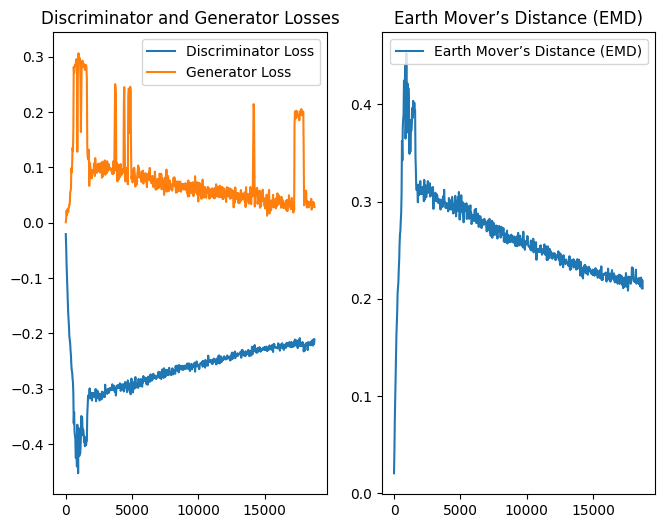

In [81]:
# Plot losses and EMD values
number_bins = 30

# Bin the discriminator losses and calculate the averages
binned_d_losses = [np.mean(d_losses[i:i + number_bins]) for i in range(0, len(d_losses), number_bins)]
binned_g_losses = [np.mean(g_losses[i:i + number_bins]) for i in range(0, len(g_losses), number_bins)]
binned_emd_values = [np.mean(emd_values[i:i + number_bins]) for i in range(0, len(emd_values), number_bins)]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(range(0, len(d_losses), number_bins), binned_d_losses, label='Discriminator Loss')
plt.plot(range(0, len(g_losses), number_bins), binned_g_losses, label='Generator Loss')
plt.legend()
plt.title('Discriminator and Generator Losses')

plt.subplot(1, 3, 2)
plt.plot(range(0, len(emd_values), number_bins), binned_emd_values, label='Earth Mover’s Distance (EMD)')
plt.legend()
plt.title('Earth Mover’s Distance (EMD)')

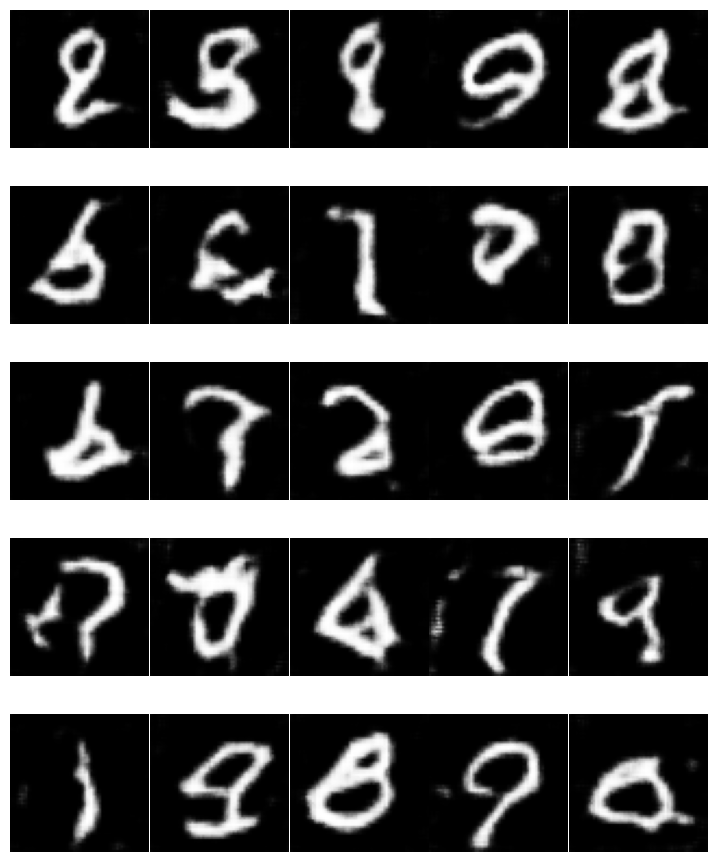

In [82]:
# Plot some generated images
x, y = 5, 5 # Grid size
plt.figure(figsize=(9,10))
for i in range(x*y):
    plt.subplot(x, y, i + 1)
    plt.imshow(generated_images[i, 0], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.0, bottom=0)

plt.show()

In [83]:
# # Training loop
# for epoch in range(num_epochs):
#     for i, (real_images, _) in enumerate(trainloader_mnist):
#         # Train Discriminator
#         discriminator.zero_grad()
        
#         real_images = Variable(real_images).to(default_device)
#         batch_size = real_images.size(0)

#         # Generate fake images
#         z = Variable(torch.randn(batch_size, z_dim, 1, 1)).to(default_device)
#         fake_images = generator(z)

#         # Discriminator output for real and fake images
#         real_outputs = discriminator(real_images)
#         fake_outputs = discriminator(fake_images.detach())

#         # Compute Wasserstein distance and backpropagate
#         discriminator_loss = -(torch.mean(real_outputs) - torch.mean(fake_outputs))
#         discriminator_loss.backward(retain_graph=True)

#         # Gradient penalty
#         epsilon = torch.rand(batch_size, 1, 1, 1).to(default_device)
#         x_hat = epsilon * real_images + (1 - epsilon) * fake_images
#         x_hat.requires_grad_(True)
#         d_hat = discriminator(x_hat)
#         gradients = torch.autograd.grad(outputs=d_hat, inputs=x_hat, grad_outputs=torch.ones(d_hat.size()).to(default_device), create_graph=True, retain_graph=True)[0]
#         gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
#         if i % 100 == 0:
#             print(f"Gradient Penalty: {gradient_penalty}")
#         gradient_penalty.backward(retain_graph=True)

#         optimizer_D.step()

#         # Train Generator
#         if i % 5 == 0:
#             generator.zero_grad()
#             fake_outputs = discriminator(fake_images)
#             generator_loss = -torch.mean(fake_outputs)
#             generator_loss.backward(retain_graph=True)
#             optimizer_G.step()

#         # Record losses
#         d_losses.append(discriminator_loss.item())
#         g_losses.append(generator_loss.item())

#         # Earth Mover’s Distance (EMD) calculation
#         emd_value = -(torch.mean(real_outputs) - torch.mean(fake_outputs)).item()
#         emd_values.append(emd_value)

#         # Print progress
#         if i % 2500 == 0:
#             print('[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f] [EMD: %.4f]' %
#                   (epoch, num_epochs, i, len(trainloader_mnist), discriminator_loss.item(), generator_loss.item(), emd_value))